# Produced a transverse Gaussian distribution with longitudinal Bane profile

In [26]:
import os
import generatorTool as gt
import numpy as np
import numpy.random as rd 
import matplotlib.pyplot as plt
from scipy import constants
from scipy.stats import halfnorm, norm
import makeopenpmd

# unit conversion:
mm=1e3

qElec  = constants.value(u'elementary charge')
mElec  = constants.value(u'electron mass')
qOm    = qElec/mElec
cLight = constants.value(u'speed of light in vacuum')



### define Bane's distribution

In [27]:
def doorsteppdfsmooth2(x, lo, up, k, zdoor, sigma_head, sigma_tail, blength):
    mynorm = (6 * blength + k**2 * np.cos(k * zdoor) * (blength - zdoor)**3 + 3 * k * np.sin(k * zdoor) * (blength - zdoor)**2)/6
    tail_value = 1 - k*zdoor*np.sin(k*zdoor) + \
              k**2*zdoor**2/2*np.cos(k*zdoor) + \
              blength * (k*np.sin(k*zdoor) - k**2 * zdoor*np.cos(k*zdoor)) + \
              k**2/2*np.cos(k*zdoor)*blength**2
    
    head_value = 1
    
    condition = [x < 0, (x >= 0) & (x <= zdoor), (x > zdoor) & (x <= blength), x > blength]
    choice = [head_value * np.exp(-(x)**2 / 2 /sigma_head**2),
              1, 1 - k*zdoor*np.sin(k*zdoor) + \
              k**2*zdoor**2/2*np.cos(k*zdoor) + \
              x * (k*np.sin(k*zdoor) - k**2 * zdoor*np.cos(k*zdoor)) + \
              k**2/2*np.cos(k*zdoor)*x**2, tail_value * np.exp(-(x - blength)**2 / 2 /sigma_tail**2)]
    
    mynorm = mynorm + np.sqrt(np.pi / 2) * sigma_tail * tail_value + np.sqrt(np.pi / 2) * sigma_head * head_value

    return np.select(condition, choice)/mynorm
global n, lo, up, zdoor, sigma_head, sigma_tail, blength, freq, wavelength, k



### Beam parameters setup

#### general parameters

In [28]:
n            = 100000  # number of macroparticles
lo           = 0.1
up           = 1.3
zdoor        = 0.25
sigma_head   = 0.01
sigma_tail   = 0.01
blength      = 3
freq         = 165e9  # frequency of the mode 
wavelength   = 299792458 / freq
k            = 2 * np.pi 
lorentz_fac  = 120   # Lorentz factor
norm_emitx   = 10e-6  # normalized emittance in x
norm_emity   = 10e-6  # normalized emittance in y
nsigma       = 2  # cut [in # of sigmas] for the Gaussian distrib.
bunchCharge  =-2e-9
print(wavelength)

0.001816923987878788


#### check temporal profile

In [29]:
def doorstepodfset(x):   
    return (doorsteppdfsmooth2(x, lo, up, k, zdoor, sigma_head, sigma_tail, blength))


Text(0, 0.5, 'population')

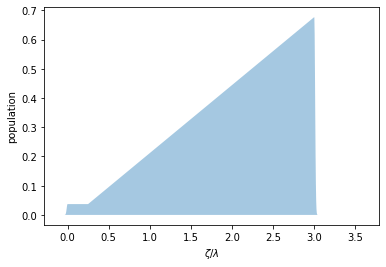

In [30]:
zz=np.linspace (-.1,blength*1.2,1001)
plt.fill_between (zz, doorstepodfset(zz),0*zz,alpha=0.4)
plt.xlabel (r'$\zeta/\lambda$')
plt.ylabel ('population')

#### Compute Courant-Snyder parameter to focus the beam after a drift of D 

In [31]:
D         = 0.24  # location of waist
sizeStar  = 1.e-4  # RMS beam size at waist
betaxStar = (sizeStar)**2/(norm_emitx/lorentz_fac)
betayStar = (sizeStar)**2/(norm_emity/lorentz_fac)

betax     = betaxStar+D**2/betaxStar
betay     = betayStar+D**2/betayStar

alphax    = D/betaxStar
alphay    = D/betayStar

gammax    = (1+alphax**2)/betax
gammay    = (1+alphay**2)/betay

print ("betaxStar",betaxStar)
print ("betax",betax)
print ("alphax",alphax)


betaxStar 0.12
betax 0.6
alphax 2.0


Text(0, 0.5, 'RMS beam sizes (m)')

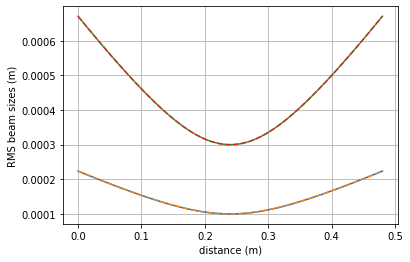

In [32]:
# check envelop
sCoor = np.linspace(0,2*D,101)

sigmX = np.sqrt((norm_emitx/lorentz_fac)*(betax+2*sCoor*(-alphax)+gammax*sCoor**2))
sigmY = np.sqrt((norm_emity/lorentz_fac)*(betay+2*sCoor*(-alphay)+gammay*sCoor**2))

plt.plot (sCoor,sigmX)
plt.plot (sCoor,sigmY,'--')
plt.plot (sCoor,3*sigmX)
plt.plot (sCoor,3*sigmY,'--')
plt.grid()
plt.xlabel ('distance (m)')
plt.ylabel ('RMS beam sizes (m)')


#### longitudinal phase space

In [33]:
dLorentz_fac = 1e-3*lorentz_fac   #        spread in Lorentzfactor
#blength      = 1e-3
ddOverdz     = 0.0   # in m^-1 -- chirp (slope)


### Generating the simulation

In [34]:
# generate the Gaussian distribution in (x,x',y,y')
emitgeomx=norm_emitx/lorentz_fac
emitgeomy=norm_emity/lorentz_fac

x, xp, y, yp = gt.gaussian_phase_space_2dof(n, alphax, betax, emitgeomx,\
                                  alphay, betay, emitgeomy, nsigma)  

# generate the longitudinal phase space:
U=  gt.Gauss_2d_cart_cut(n,1e-10,2.0)

#z    = blength*U[0,:]; 
z    = wavelength*gt.mc_1D(n, doorstepodfset, -0.2, 3.3, maxFunc=1.1)
# linearly-chirped longitudinal phase space
dp  = dLorentz_fac*U[1,:]+ ddOverdz*z

dpp =dp/lorentz_fac

#### plotting the results

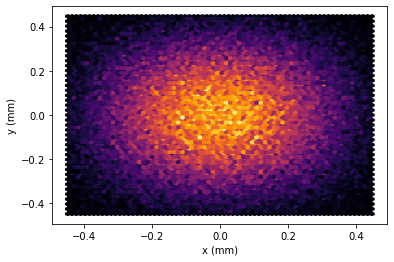

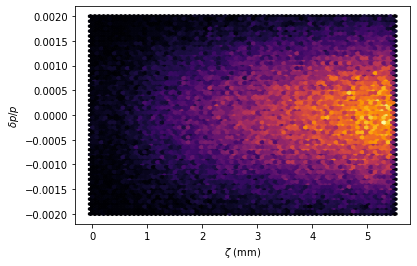

(array([ 27.,  37.,  63.,  35.,  49.,  46.,  45.,  38.,  65.,  34.,  57.,
         45.,  34.,  45.,  53.,  40.,  38.,  61.,  30.,  51.,  65.,  37.,
         51.,  47.,  48.,  50.,  76.,  63.,  62.,  75.,  78.,  76.,  79.,
         91.,  88.,  78., 116.,  86., 105., 119., 101., 109., 107., 113.,
        131., 130., 130., 127., 135., 137., 159., 132., 140., 156., 148.,
        173., 162., 178., 177., 177., 170., 160., 184., 203., 169., 209.,
        198., 209., 191., 201., 209., 227., 202., 233., 221., 236., 245.,
        224., 241., 255., 214., 274., 271., 233., 256., 293., 239., 266.,
        300., 270., 265., 283., 285., 296., 288., 280., 303., 327., 295.,
        293., 313., 325., 326., 308., 346., 330., 329., 348., 335., 345.,
        353., 347., 363., 346., 373., 379., 366., 369., 375., 391., 364.,
        398., 385., 403., 399., 390., 414., 407., 399., 417., 413., 406.,
        438., 438., 442., 413., 443., 433., 433., 438., 467., 455., 461.,
        460., 457., 481., 464., 489., 

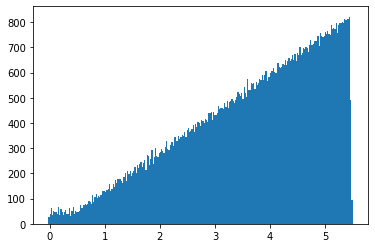

In [35]:
plt.hexbin (mm*x,mm*y, gridsize=70, cmap='inferno')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.show()
plt.hexbin (mm*z,dpp, gridsize=70, cmap='inferno')
#plt.plot (z,dpp,'.')
plt.xlabel(r'$\zeta$ (mm)')
plt.ylabel(r'$\delta p/p$ ')
plt.show()
plt.hist(mm*z,251)

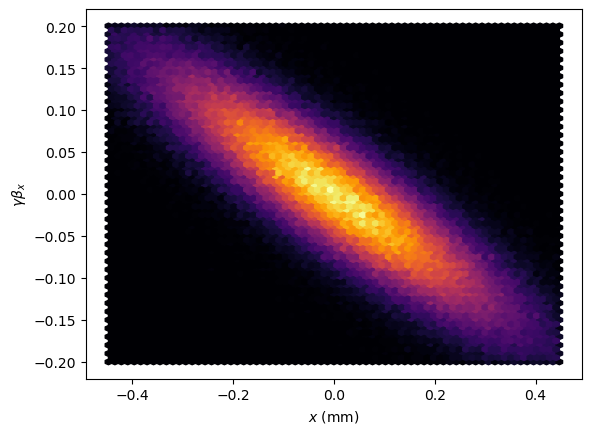

In [114]:
plt.hexbin (mm*x,xp*(1+dpp)*lorentz_fac, gridsize=70, cmap='inferno')
plt.xlabel(r'$x$ (mm)')
plt.ylabel(r'$\gamma\beta_x$')
plt.show()

### Saving to pit file for CST

In [115]:
# rewrite the momentum in units of gamma*beta_i 
# (assume relativistic beam here)/


px=xp*(1+dpp)*lorentz_fac
py=yp*(1+dpp)*lorentz_fac
pz=(1+dpp)*lorentz_fac
print(z)

[0.0016182  0.00307174 0.00052804 ... 0.00169769 0.00359978 0.00249827]


In [116]:
# dump into a warpX-readable file
# warpX wants SI units so

#px *= mElec*cLight
#py *= mElec*cLight
#pz *= mElec*cLight

#makeopenpmd.make_openPMD(x, y, z, px, py, pz, 'init.h5', bunchCharge)


In [117]:
m=10 #always 10 for pit
w, h = m, n
pitarray = [[0 for x in range(w)] for y in range(h)]
mass = np.empty(n)
charge = np.empty(n)
time = np.empty(n)
chargem = np.empty(n)
momz = np.empty(n)

i=0
for i in range(n):
    mass[i] = 9.11e-31
    charge[i] = 1.6e-19
    time[i] = 0.0e-9#Note: t=0 for all particles means beam is imported at 0 and does not enter structure from beginning
    chargem[i] = (10e-9)/n #Note: each macroparticle corresponds to 1 electron if chargem=charge
    momz[i] = pz[i]

i=0
while i<n:
    pitarray[i][0] = x[i]*2#*.2#
    pitarray[i][1] = y[i]*2#*.2
    pitarray[i][2] = z[i]*-1-.01
    pitarray[i][3] = px[i]
    pitarray[i][4] = py[i]
    pitarray[i][5] = momz[i]
    pitarray[i][6] = mass[i]
    pitarray[i][7] = charge[i]
    pitarray[i][8] = chargem[i]
    pitarray[i][9] = time[i]
    i=i+1
np.savetxt('banewaisttest2r2lf165.pit', pitarray, delimiter=' ')